<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/LayerNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Questions and answers

- LN can be used in different settings depending what dimenions are used for normalization. check the torch documentation.
- If we were to normalize only the last dim, how many mu, sigma, gamma, and beta would you have?
  - If input is (B, C, H, W) and we are normalizing with layer norm in the last dimension
  - mu, sigma, gamma, beta will have shape (W).
- If we were to normalize all dimenions except the batch, how many mu, sigma, gamma, and beta would you have?
  - If we normalizing all dimensions except batch, mu, sigma, gamma, beta will have shape (C, H, W)
  - If number of groups = 1 in group norm, group norm normalizes all dimensions except batch.
- For the use case above, can you use repurpose GN for layer normalization? (hint: affine part; per-ch vs. per-element shift/scale)
```
x1 = x1.permute(0, 3, 1, 2) # reshape to (100, 28, 3, 28)
gn_last_dim = nn.GroupNorm( num_channels=28 , num_groups=1)
gn_last_dim(x1).permute(0, 2, 3, 1).shape, gn_last_dim.weight.shape, gn_last_dim.bias.shape
```
-How does it work for 2D, 3D, and 4D tensors? https://nn.labml.ai/normalization/layer_norm/index.html
- Why is LN the right choice for text transformers?
  - Input sequence can be of different lengths, normalizing within a sequence is easier.
- What about vision transformer?
  - Generally in vision tasks, BN was more common. Since transformers inherit architecture and methods from NLP, vision transformers inherited LN.
  - This paper shows that by adding BN blocks betwen layers in each feed forward neural network block, you can make BN work in vision transformers.
  - https://openaccess.thecvf.com/content/ICCV2021W/NeurArch/papers/Yao_Leveraging_Batch_Normalization_for_Vision_Transformers_ICCVW_2021_paper.pdf

## Notes

- Why normalize
  - The closer dataset resembles a multivariate gaussian distribution, the faster deep learning systems can learn.
  - Good idea to have zero mean, unit variance for all layers [Group Norm](https://www.youtube.com/watch?v=l_3zj6HeWUE&ab_channel=YannicKilcher)
- In distributed training, it is common to have smaller batch sizes. Batch norm does not work with smaller batch sizes
- Group norm normalizes without needing batch statistics.


### Batch Norm

- BatchNorm2D normalizes inputs across data points
- When batch size is large enough, it should work pretty well
- $x' = gamma * (x-mu)/sigma + beta$
  - gamma, beta are learnable parameters of shape (c, )
  - setting affine = false in pytorch2d freezes them 1, 0
  - mu, sigma are learnable parameters of shape (c, )
- Problems with batch norm
  - Does not work with small batch sizes
  - Tricky to make it work with sequence data since samples have different lengths

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
x = torch.randn((100, 18, 28, 28))*1000 + 500

In [4]:
bn = nn.BatchNorm2d( num_features=18 )
bn(x).shape, bn.running_mean.shape, bn.running_var.shape, bn.weight.shape, bn.bias.shape

(torch.Size([100, 18, 28, 28]),
 torch.Size([18]),
 torch.Size([18]),
 torch.Size([18]),
 torch.Size([18]))

In [5]:
bn.running_mean

tensor([50.6280, 50.0555, 49.5979, 50.2733, 50.1081, 50.4729, 50.3562, 49.8952,
        50.3879, 50.1281, 50.2935, 50.4150, 49.9404, 50.1635, 50.1813, 49.6712,
        50.0675, 49.5701])

### Layer Norm
- Normalize each image independently. Running mean and running variance are not tracked
- Loses difference in variance between channels
- Details
  - $x' = gamma * (x-mu)/sigma + beta$
  - mu = mean(x, dims_to_normalize) # shape of mu will be the normalized dimensions.
  - sigma = std(x, dims_to_normalize) # shape of sigma will be the normalized dimensions
  - gamma, beta are learnable parameters whose shape will match mu, sigma with affine = true.
  - If affine = false, gamma, beta are set to 1 and 0.
- If input is (B, C, H, W) and we are normalizing with layer norm in the last dimension
  - mu, sigma, gamma, beta will have shape (W).
- If we normalizing all dimensions except batch, mu, sigma, gamma, beta will have shape (C, H, W)
- If number of groups = 1 in group norm, group norm normalizes all dimensions except batch.

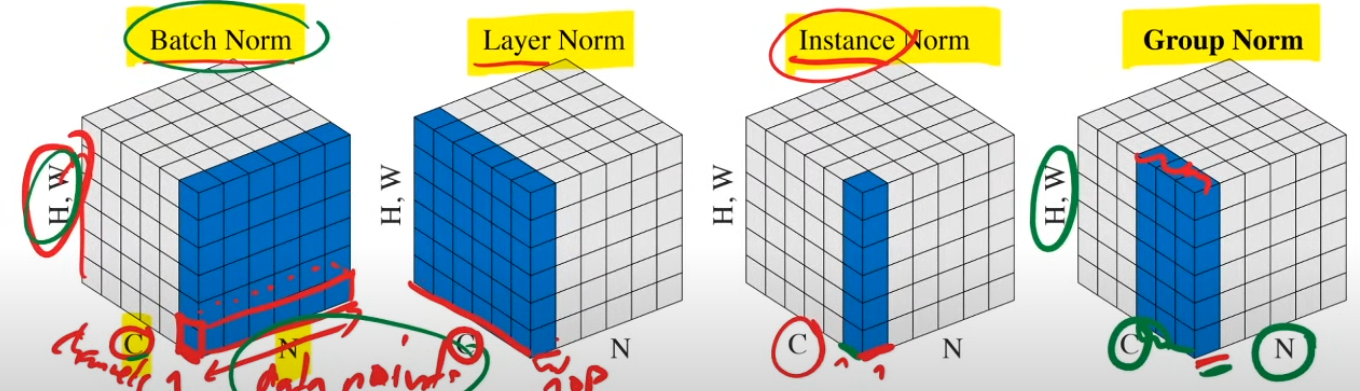

In [11]:
x = torch.randn((100, 5, 28, 28))*1000 + 500
ln = nn.GroupNorm( num_channels=5 , num_groups=1, affine=True)
ln(x).shape, ln.weight.shape, ln.bias.shape, ln.weight, ln.bias

(torch.Size([100, 5, 28, 28]),
 torch.Size([5]),
 torch.Size([5]),
 Parameter containing:
 tensor([1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True))

In [24]:
a = torch.randn((100, 10, 2))
torch.mean(a, dim=2).shape

torch.Size([100, 10])

### Layer norm of last dim

In [30]:
x1 = torch.randn((100, 5, 28, 28))*10 + 500
ln_last_dim = nn.LayerNorm([28])
ln_last_dim(x1).shape, ln_last_dim.weight.shape, ln_last_dim.bias.shape, ln_last_dim.weight

(torch.Size([100, 5, 28, 28]),
 torch.Size([28]),
 torch.Size([28]),
 Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True))

- Normalize over last dimension, but do it with Group Norm

In [28]:
x1 = x1.permute(0, 3, 1, 2) # reshape to (100, 28, 3, 28)
gn_last_dim = nn.GroupNorm( num_channels=28 , num_groups=1)
gn_last_dim(x1).permute(0, 2, 3, 1).shape, gn_last_dim.weight.shape, gn_last_dim.bias.shape

(torch.Size([100, 28, 5, 28]), torch.Size([28]), torch.Size([28]))

### Layer norm of all dimensions

- Normalize over all dimensions except batch in (N, C, H, W) but do it with layer norm

In [29]:
x1 = torch.randn((100, 3, 28, 28))*10 + 500
ln_all_dim = nn.LayerNorm([3, 28, 28])
ln_all_dim(x1).shape, ln_all_dim.weight.shape, ln_all_dim.bias.shape

(torch.Size([100, 3, 28, 28]),
 torch.Size([3, 28, 28]),
 torch.Size([3, 28, 28]))

### Instance norm
- Features should be normalized individually
- keeps difference in variance between channels

In [ ]:
insnorm = nn.GroupNorm( num_channels=3 , num_groups=3)
insnorm(x).shape

torch.Size([100, 3, 28, 28])

### Group norm
- Intermediate between instance and layer norm
- Convert N,C,H,W into N,G,C/G,H,W and normalize over the last 3 dimensions
- Brings a new hyper paramater of number of groups, don't like it
- It would be useful for distributed ML, where we might have low batch sizes

- Group norm code

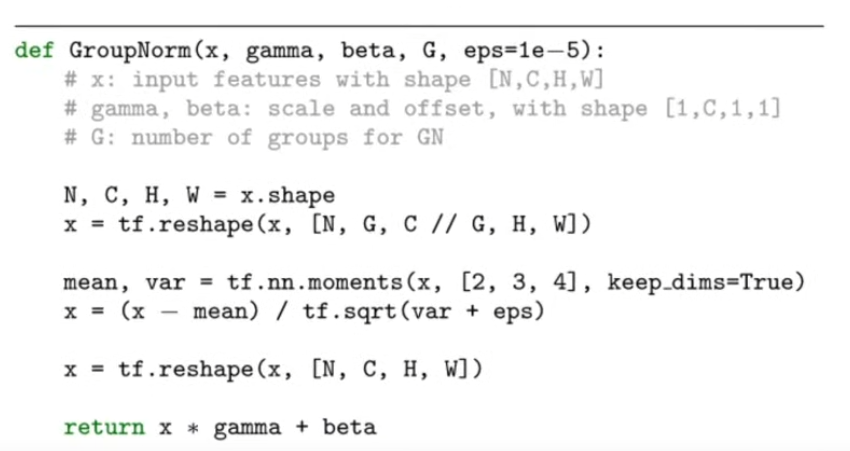